In [1]:
#Dependencies
# xarray, cfgrib

In [26]:
satellite_folder = '/perm/rd/pamc/Land/MODIS/AquaDay/' #Recommend saving all satellite files to the same folder
era_folder = '/perm/rd/pamc/Land/ERA/'

In [21]:
local_times = {"aquaDay":"13:30",
               "terraDay":"10:30",
               "terraNight":"22:30",
               "aquaNight":"01:30"
              }

min_hours = {"aquaDay":2,
            "terraDay":-1,
            "aquaNight":-1,
            "terraNight":11}
max_hours = {"aquaDay":24,
            "terraDay":22,
            "aquaNight":13,
            "terraNight":24}

satellite = 'aquaDay'

In [4]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def get_satellite_slice(date : str,
                        utc_hour : int,
                        satellite='aquaDay',
                        latitude_bound = None):
    #Due to crossing of the datetime, some times will be saved different date
    if utc_hour < min_hours[satellite]:
        file_date = str((np.datetime64(date) - np.timedelta64(1,'D')))
    elif utc_hour > max_hours[satellite]:
        file_date = str((np.datetime64(date) + np.timedelta64(1,'D')))
    else:
        file_date = date
    #Open .tif file
    sat_xr = xr.open_rasterio(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif')
    #Rename spatial dimensions
    sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})
    #Create time delta to change local to UTC
    time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 
    #Convert local satellite time to UTC and round to nearest hour
    time = (pd.to_datetime([file_date + " " + local_times[satellite]]*time_delta.shape[0]) - time_delta).round('H')
    #print(time)
    #Select desired hour
    dt = np.datetime64(f'{date} {utc_hour:02}:00:00')
    right_time = np.expand_dims(time == dt,axis=(0,1))
    if right_time.sum() == 0:
        print("Warning: Correct time not found in dataset, likely problem in file selection")
    #Make subset
    subset = np.logical_and(np.isfinite(sat_xr),right_time)
    if subset.sum() == 0:
        print(f"Warning: No valid data found for {date} {utc_hour:02}h")
    if latitude_bound is not None:
        #print(f"Subsetting < {latitude_bound}")
        subset = np.logical_and(subset,np.expand_dims(np.abs(sat_xr.latitude) < latitude_bound,axis=(0,-1)))
    #Select valid data
    test_subset = sat_xr.where(subset).load()
    sat_xr.close()
    sat_xr = None
    return test_subset[0,::-1,:]

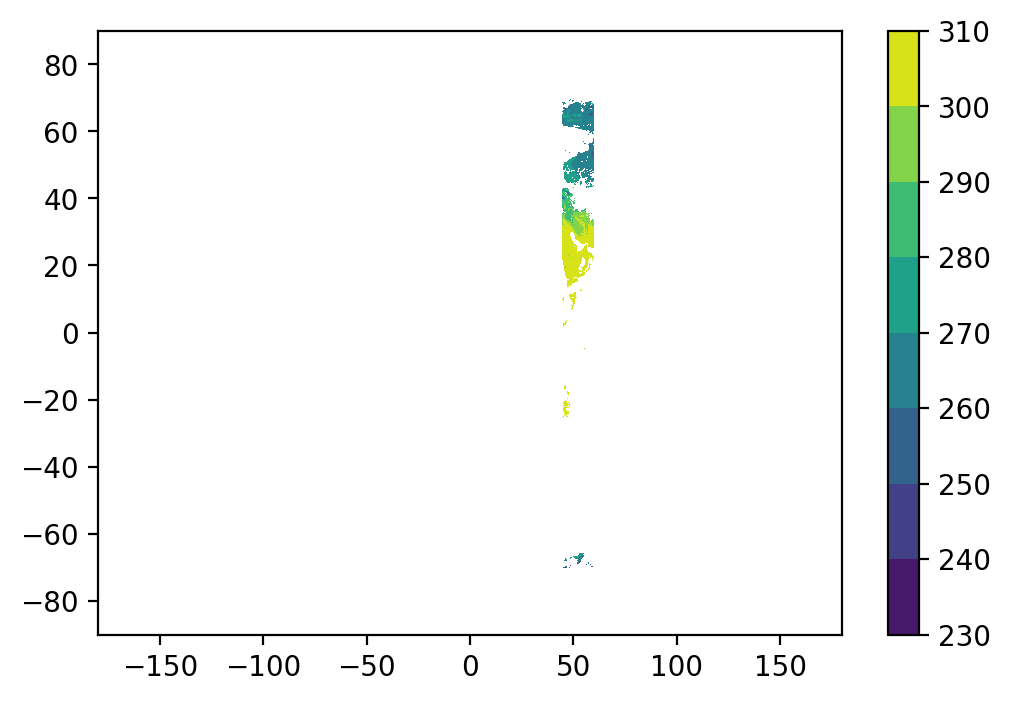

In [42]:

test_data = get_satellite_slice('2018-01-03',10,latitude_bound=70)
plt.figure(dpi=200)
xv, yv = np.meshgrid(test_data.longitude, test_data.latitude, indexing='xy')
plt.contourf(xv,yv,test_data,levels=np.arange(230,320,10))
plt.colorbar()

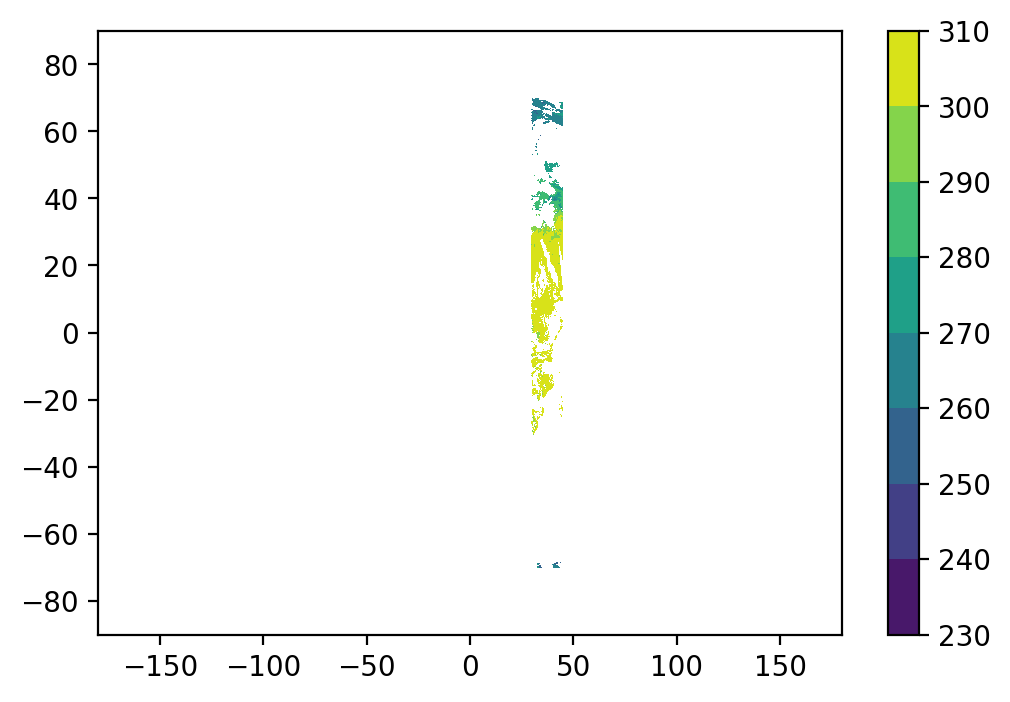

In [43]:

test_data = get_satellite_slice('2018-01-03',11,latitude_bound=70)
plt.figure(dpi=200)
xv, yv = np.meshgrid(test_data.longitude, test_data.latitude, indexing='xy')
plt.contourf(xv,yv,test_data,levels=np.arange(230,320,10))
plt.colorbar()

In [30]:
def get_era_data(date : str,
                 utc_hour : int,
                 field = 't2m'):

    month = '_'.join(date.split('-')[:-1])
    ds_era = xr.open_dataset(f'{era_folder}/sfc_unstructured_{month}.grib',engine='cfgrib')
    #Grab correct field
    da = ds_era[field]
    #
    time_str = f"{date} {utc_hour:02}:00:00" 
    da = da.sel(time='2018-01-01 00:00:00')
    #Relabel longitude coordinate to be consistent.
    da = da.assign_coords({"longitude": (((da.longitude + 180) % 360) - 180)})
    
    #Load data, perhaps this is too early?
    da = da.load()
    
    #Close file
    ds_era.close()
    return da

In [44]:
da = get_era_data('2018-01-03',10)

In [45]:
def grid_plot_era(da):
    from scipy.interpolate import griddata
    xi = np.linspace(-180, 180, 1024)
    yi = np.linspace(-89.95,89.95,512)
    xi, yi = np.meshgrid(xi, yi)

    x, y, z = da.longitude.data, da.latitude.data, da.data
    zi = griddata((x,y), z, (xi, yi))
    
    plt.figure(dpi=200)
    plt.contourf(xi,yi,zi,levels=np.arange(230,320,10))
    plt.colorbar()
    plt.show()

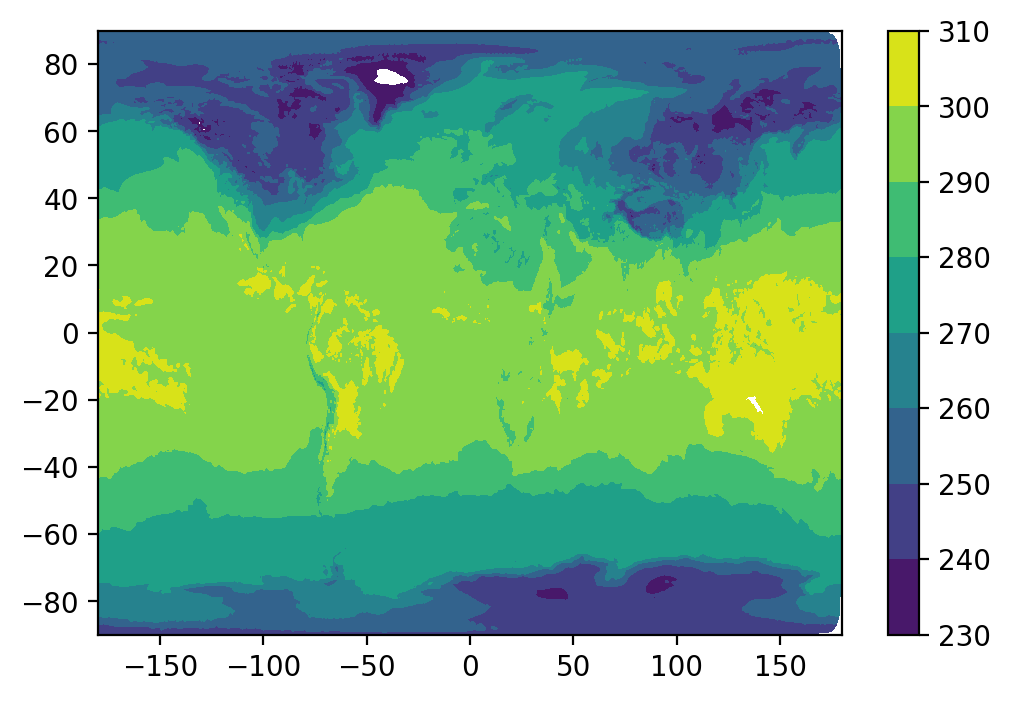

In [46]:
grid_plot_era(da)